In [3]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# we used google colab to to train our model therefore i can not change the paths
# I would need to download big sized libraries in order to run this notebook
# if you would like to test this notebook please configure the paths

In [ ]:
# below is the google colab share link, it should work without the need of changing paths

#https://colab.research.google.com/drive/1Qw7S-OSUbZunYMyZ9nytXE4OuauZiTcw?usp=sharing

In [4]:
df = pd.read_csv('/content/drive/MyDrive/tr_hate_eval.csv')

df

,text,HS
0,#eşcinsellik sapıklığına nasıl ki cinsel yönel...,1
1,"Lut kavminin çirkin işini yapanı görürseniz, f...",1
2,"şakalarımı anlamıyolar, neymiş efendim toplulu...",1
3,Ermeni vampir gibi kanımızı içecek Sonra bir a...,1
4,Yıllarca okul okuyup kendini geliştirmemiş yob...,1
...,...,...
995,"Fuat bey, gazeteciler arasında İtalya mafyası ...",0
996,he yok inglizce yetmiyomus gibi italyanca ödev...,0
997,atalanta başkanının italyanca gel bide arkadan...,0
998,türkçe ingilizce kuş dili biliyorum akıcı sevi...,0


In [5]:
df['text'][0]


'#eşcinsellik sapıklığına nasıl ki cinsel yönelim özgürlüğü dediniz, #pedofili sapıklığı da onu referans alıp kendine alan açmaya çalışacaktır. Her türlü cinsel aşırılıkla mücadele şarttır!'

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('turkish'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .9

In [8]:
texts = []
labels = []

with open("/content/drive/MyDrive/tr_hate_eval.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    punctuation='#@/\,;.:!?$123456789¿¡'
    table=str.maketrans(dict.fromkeys(punctuation))

    next(reader)
    for row in reader:
        labels.append(row[1])
        text = row[0].lower()
        text = text.translate(table)
        for word in STOPWORDS:
            token = ' ' + word + ' '
            text = text.replace(token, ' ')
            text = text.replace(' ', ' ')
        texts.append(text)

In [9]:
# text after preproccing

texts[:5]

['eşcinsellik sapıklığına cinsel yönelim özgürlüğü dediniz pedofili sapıklığı onu referans alıp kendine alan açmaya çalışacaktır türlü cinsel aşırılıkla mücadele şarttır',
 'lut kavminin çirkin işini yapanı görürseniz faili mef’ulü öldürünüz”',
 'şakalarımı anlamıyolar neymiş efendim topluluk içinde laap pantolon indirilmezmiş yobazsınız yobaz',
 'ermeni vampir kanımızı içecek sonra bir ateşkesle acımız geçecek rüzgarı ekenler fırtınayı biçecek türk milleti diyor yaydan çıktı ok artık karabağ ölüm başka yolu yok artik',
 'yıllarca okul okuyup kendini geliştirmemiş yobaz insanları gördükçe ağzım açık kalıyor']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.10, random_state=42)

y_train = np.array(y_train, dtype=np.int)
y_test = np.array(y_test, dtype=np.int)

In [11]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index


In [12]:
train_sequences = tokenizer.texts_to_sequences(X_train)


In [13]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_padded.shape

(900, 200)

In [14]:

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [15]:
# printing shapes of our objects

print('train padded x shape = ', train_padded.shape)
print('test padded x shape = ', test_padded.shape)
print('train padded y shape = ', y_train.shape)
print('test padded y shape = ', y_test.shape)

train padded x shape =  (900, 200)
test padded x shape =  (100, 200)
train padded y shape =  (900,)
test padded y shape =  (100,)


In [16]:
model_bidirectionalLSTM = Sequential()

model_bidirectionalLSTM.add(Embedding(vocab_size, embedding_dim))
model_bidirectionalLSTM.add(Dropout(0.1))
model_bidirectionalLSTM.add(Bidirectional(LSTM(embedding_dim)))
model_bidirectionalLSTM.add(Dense(1, activation= 'sigmoid'))

model_bidirectionalLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 386,177
Trainable params: 386,177
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_bidirectionalLSTM.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [18]:
num_epochs = 10
history_bidrectional = model_bidirectionalLSTM.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test), verbose=1)


Epoch 1/10
29/29 [==============================] - 11s 244ms/step - loss: 0.6912 - accuracy: 0.5451 - val_loss: 0.6691 - val_accuracy: 0.7000
Epoch 2/10
29/29 [==============================] - 6s 203ms/step - loss: 0.6544 - accuracy: 0.6634 - val_loss: 0.5895 - val_accuracy: 0.7200
Epoch 3/10
29/29 [==============================] - 6s 201ms/step - loss: 0.5166 - accuracy: 0.7825 - val_loss: 2.0004 - val_accuracy: 0.5300
Epoch 4/10
29/29 [==============================] - 6s 202ms/step - loss: 0.6039 - accuracy: 0.8113 - val_loss: 0.5239 - val_accuracy: 0.7600
Epoch 5/10
29/29 [==============================] - 6s 200ms/step - loss: 0.2111 - accuracy: 0.9717 - val_loss: 0.5303 - val_accuracy: 0.7600
Epoch 6/10
29/29 [==============================] - 6s 198ms/step - loss: 0.1043 - accuracy: 0.9788 - val_loss: 0.5916 - val_accuracy: 0.7500
Epoch 7/10
29/29 [==============================] - 6s 198ms/step - loss: 0.0725 - accuracy: 0.9941 - val_loss: 0.6150 - val_accuracy: 0.7300
Epoch

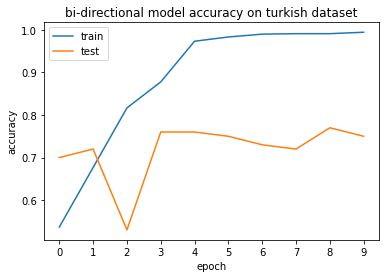

In [19]:
plt.plot(history_bidrectional.history['accuracy'])
plt.plot(history_bidrectional.history['val_accuracy'])
plt.title('bi-directional model accuracy on turkish dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(0,10,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [21]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_tranformer = keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model_tranformer.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history_transformer = model_tranformer.fit(train_padded, y_train, batch_size=32, epochs=10, validation_data=(test_padded, y_test))

Epoch 1/10
29/29 [==============================] - 7s 194ms/step - loss: 0.7762 - accuracy: 0.4783 - val_loss: 0.6898 - val_accuracy: 0.5300
Epoch 2/10
29/29 [==============================] - 5s 183ms/step - loss: 0.6988 - accuracy: 0.5189 - val_loss: 0.6892 - val_accuracy: 0.4900
Epoch 3/10
29/29 [==============================] - 5s 182ms/step - loss: 0.6939 - accuracy: 0.5258 - val_loss: 0.6897 - val_accuracy: 0.5300
Epoch 4/10
29/29 [==============================] - 5s 182ms/step - loss: 0.6861 - accuracy: 0.5395 - val_loss: 0.6746 - val_accuracy: 0.5300
Epoch 5/10
29/29 [==============================] - 5s 184ms/step - loss: 0.6605 - accuracy: 0.6243 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 6/10
29/29 [==============================] - 5s 184ms/step - loss: 0.7075 - accuracy: 0.5546 - val_loss: 0.6632 - val_accuracy: 0.6600
Epoch 7/10
29/29 [==============================] - 5s 183ms/step - loss: 0.6475 - accuracy: 0.6354 - val_loss: 0.6104 - val_accuracy: 0.7100
Epoch 

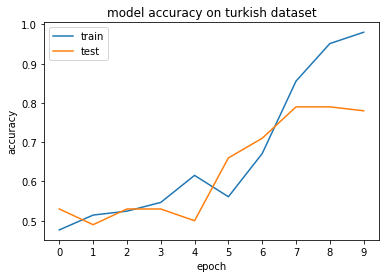

In [24]:
plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('model accuracy on turkish dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(10))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
rnn_model = Sequential()
#rnn_model.add(layers.Input(shape=(max_length,)))
#rnn_model.add(TokenAndPositionEmbedding(max_length, vocab_size, embedding_dim))
rnn_model.add(Embedding(vocab_size, embedding_dim))
rnn_model.add(layers.LSTM(units=64, activation='tanh', return_sequences=True))
rnn_model.add(layers.LSTM(units=64, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.1))
#rnn_model.add(Flatten())
rnn_model.add(Dense(units=1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           65        
Total params: 386,113
Trainable params: 386,113
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_lstm = rnn_model.fit(train_padded, y_train, batch_size=32, epochs=10, validation_data=(test_padded, y_test))

Epoch 1/10
29/29 [==============================] - 10s 244ms/step - loss: 0.6930 - accuracy: 0.5059 - val_loss: 0.6917 - val_accuracy: 0.5300
Epoch 2/10
29/29 [==============================] - 7s 248ms/step - loss: 0.6912 - accuracy: 0.5436 - val_loss: 0.6921 - val_accuracy: 0.5300
Epoch 3/10
29/29 [==============================] - 7s 245ms/step - loss: 0.6923 - accuracy: 0.5302 - val_loss: 0.6913 - val_accuracy: 0.5300
Epoch 4/10
29/29 [==============================] - 7s 246ms/step - loss: 0.6911 - accuracy: 0.5244 - val_loss: 0.6866 - val_accuracy: 0.5300
Epoch 5/10
29/29 [==============================] - 7s 250ms/step - loss: 0.6846 - accuracy: 0.5477 - val_loss: 0.6860 - val_accuracy: 0.5097
Epoch 6/10
29/29 [==============================] - 7s 253ms/step - loss: 0.6730 - accuracy: 0.5385 - val_loss: 0.6236 - val_accuracy: 0.7120
Epoch 7/10
29/29 [==============================] - 7s 246ms/step - loss: 0.3159 - accuracy: 0.9157 - val_loss: 0.8129 - val_accuracy: 0.6364
Epoch

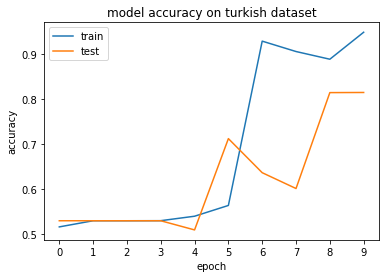

In [27]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy on turkish dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(10))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

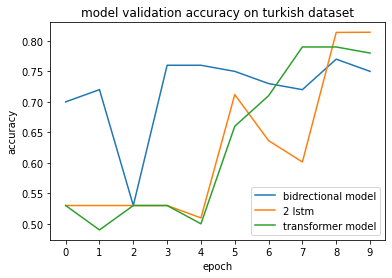

In [28]:
plt.plot(history_bidrectional.history['val_accuracy'], label='bidrectional model')
plt.plot(history_lstm.history['val_accuracy'], label= '2 lstm')
plt.plot(history_transformer.history['val_accuracy'], label = 'transformer model')
plt.xticks(np.arange(10))
plt.title('model validation accuracy on turkish dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

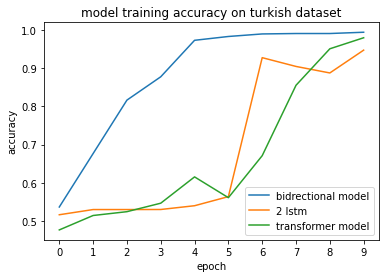

In [29]:
plt.plot(history_bidrectional.history['accuracy'], label='bidrectional model')
plt.plot(history_lstm.history['accuracy'], label= '2 lstm')
plt.plot(history_transformer.history['accuracy'], label = 'transformer model')
plt.xticks(np.arange(10))
plt.title('model training accuracy on turkish dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

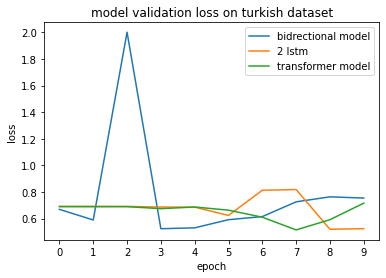

In [34]:
plt.plot(history_bidrectional.history['val_loss'], label='bidrectional model')
plt.plot(history_lstm.history['val_loss'], label= '2 lstm')
plt.plot(history_transformer.history['val_loss'], label = 'transformer model')
plt.xticks(np.arange(10))
plt.title('model validation loss on turkish dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

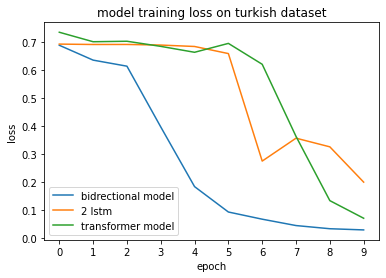

In [33]:
plt.plot(history_bidrectional.history['loss'], label='bidrectional model')
plt.plot(history_lstm.history['loss'], label= '2 lstm')
plt.plot(history_transformer.history['loss'], label = 'transformer model')
plt.xticks(np.arange(10))
plt.title('model training loss on turkish dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()